# COMPARISON OF SEARCH ALGORITHMS
### *MATEO SERRATO*


This project aims to compare uninformed and informed search algorithms using the Mexico City Metro network.


### DESCRIPTION
The collective transportation system of Mexico City has 12 lines and more than 180 different connections. We use the following CSV files:

estaciones.csv: contains a list of the subway stations and their respective coordinates.

conexiones.csv: contains the direct connections between stations, including the distance in meters.


### Lets breakdown this problem:
Finding routes in this network can be formulated as a search problem:

States → stations.

Actions → moving along a track segment to a neighboring station.

Cost → the length of the segment (in meters).

### Building and Visualizing the graph

In [1]:
#Loading the data from the .csv's
import pandas as pd
connections_data = pd.read_csv('conexiones.csv')
stations_data = pd.read_csv('estaciones.csv')



In [2]:
print(f"Columns of connections.csv: {list(connections_data.columns)}")
print(f"Columns of stations.csv: {list(stations_data.columns)}")


Columns of connections.csv: ['Origen', 'Destino', 'Longitud']
Columns of stations.csv: ['X', 'Y', 'SISTEMA', 'NOMBRE', 'LINEA', 'EST', 'CVE_EST', 'CVE_EOD17', 'TIPO', 'ALCALDIAS', 'AÑO']


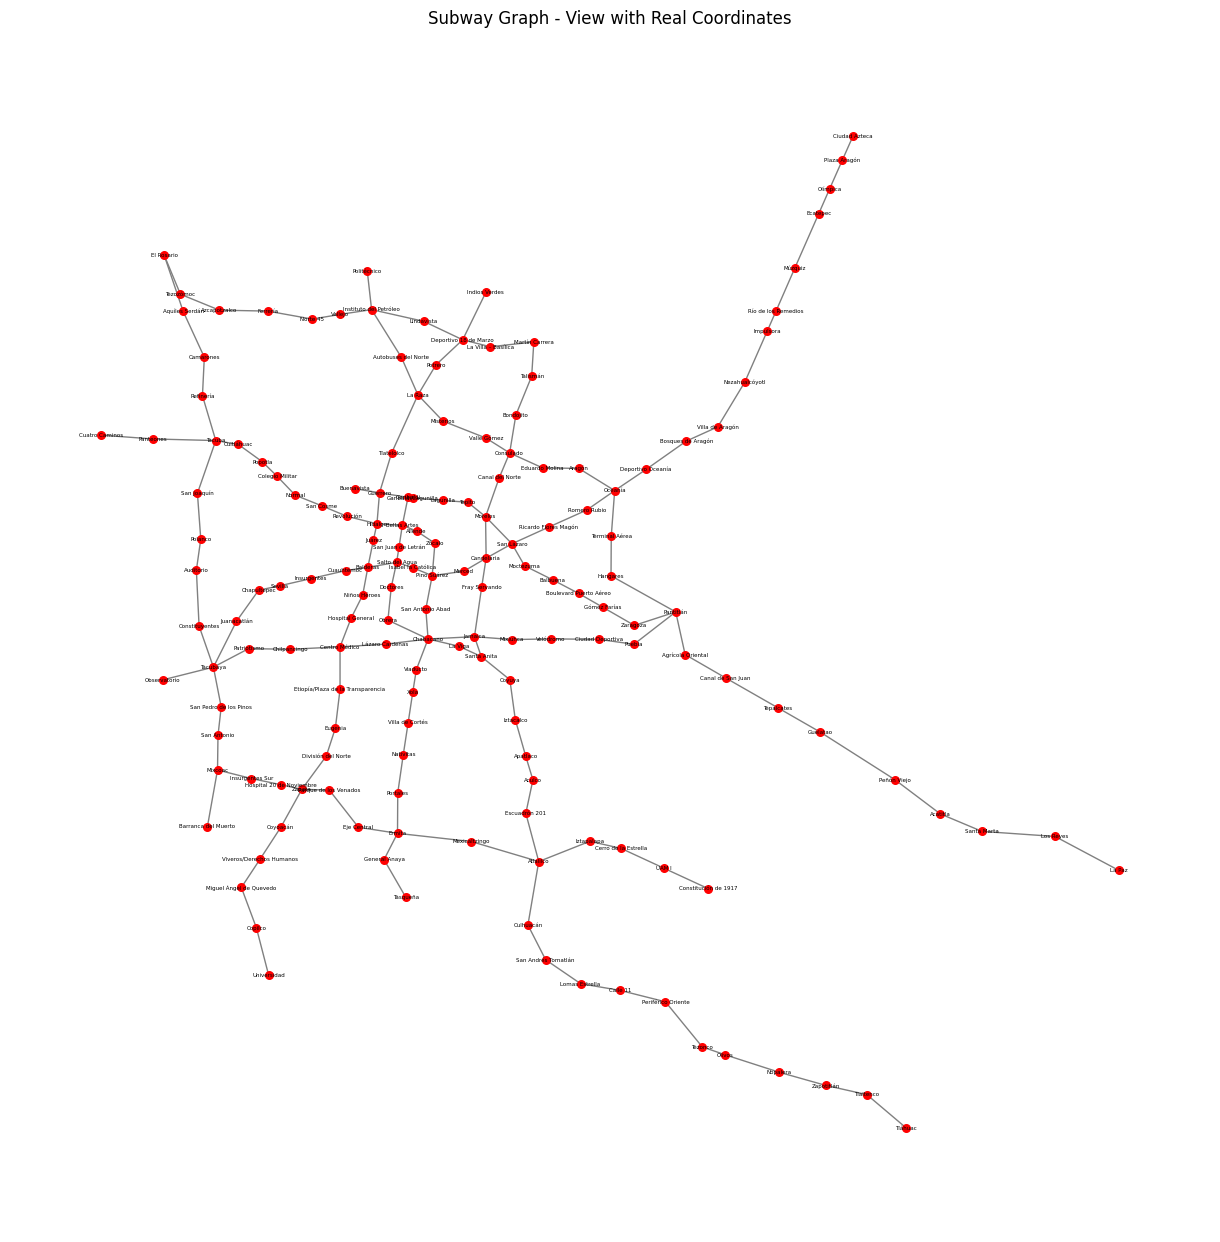

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# Add nodes using Name as ID
for _, row in stations_data.iterrows():
    nombre = row["NOMBRE"]
    G.add_node(nombre, 
               x=row["X"],
               y=row["Y"],
               linea=row["LINEA"],
               sistema=row["SISTEMA"])
#Add edges
for _, row in connections_data.iterrows():
    origen = row["Origen"]
    destino = row["Destino"]
    longitud = row["Longitud"]

    G.add_edge(origen, destino, weight=longitud)

#Using real coords to draw
pos = {n: (data["x"], data["y"]) for n, data in G.nodes(data=True)}

plt.figure(figsize=(12, 12))

nx.draw(
    G,
    pos,
    node_size=30,
    node_color="red",
    with_labels=True,
    font_size=4,
    edge_color="gray",
    
)

plt.title("Subway Graph - View with Real Coordinates")
plt.axis("equal")  
plt.show()

import matplotlib.pyplot as plt
import networkx as nx

def plot_route(G, route, pos, color="blue", title="Ruta"):


    plt.figure(figsize=(14, 14))
    nx.draw(
        G, pos,
        node_size=40,
        node_color="lightgray",
        edge_color="gray",
        with_labels=False
    )
    inicio = route[0]
    fin = route[-1]

    nx.draw_networkx_nodes(G, pos, nodelist=[inicio], node_color="limegreen", node_size=120)
    nx.draw_networkx_nodes(G, pos, nodelist=[fin], node_color="red", node_size=120)

    route_edges = list(zip(route[:-1], route[1:]))

    nx.draw_networkx_edges(G, pos, edgelist=route_edges, width=3, edge_color=color)


    labels = {node: node for node in route}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    plt.title(title)
    plt.axis("equal")
    plt.show()


### IMPLEMENTATION OF SEARCH ALGORITHMS

I'll be using three different algorithms to solve the following problems:

1-. Find the route with the least amount of stations from "Terminal Aérea" (starting Node) to "Hospital General" (Ending Node)

2-. Find the route with the least possible cost in meters between the stations mentioned before 

#### BFS
 I will use BFS to solve the first problem because we dont need the cost between nodes and this algorithm matches perfectly with the requierements, BFS explores a graph by layers, first, it visits the nodes with distance = 1, then distance = 2 and so forth, thats why it garantees that we will find a route with least amount of edges between nodes (if it exists)

In [4]:
from collections import deque

def bfs(grafo, inicio, meta):
    # FIFO
    cola = deque([inicio])

    # Visited nodes 
    visitados = set([inicio])

    #Dict to build the shortest path 
    padre = {inicio: None}

    # Main loop
    while cola:
        actual = cola.popleft()

        # If we achive the goal we stop searching 
        if actual == meta:
            break

        # Check the closest nodes of the actual node and add them to a list
        for vecino in grafo[actual]:
            if vecino not in visitados:
                visitados.add(vecino)
                padre[vecino] = actual
                cola.append(vecino)

    #  Reconstructing the path 
    if meta not in padre:
        return None  # No hay ruta

    camino = []
    nodo = meta
    while nodo is not None:
        camino.append(nodo)
        nodo = padre[nodo]

    camino.reverse()
    return camino


In [5]:
ruta = bfs(G, "Terminal Aérea", "Hospital General")
print(ruta)


['Terminal Aérea', 'Oceanía', 'Romero Rubio', 'Ricardo Flores Magón', 'San Lázaro', 'Candelaria', 'Fray Servando', 'Jamaica', 'Chabacano', 'Lázaro Cardenas', 'Centro Médico', 'Hospital General']


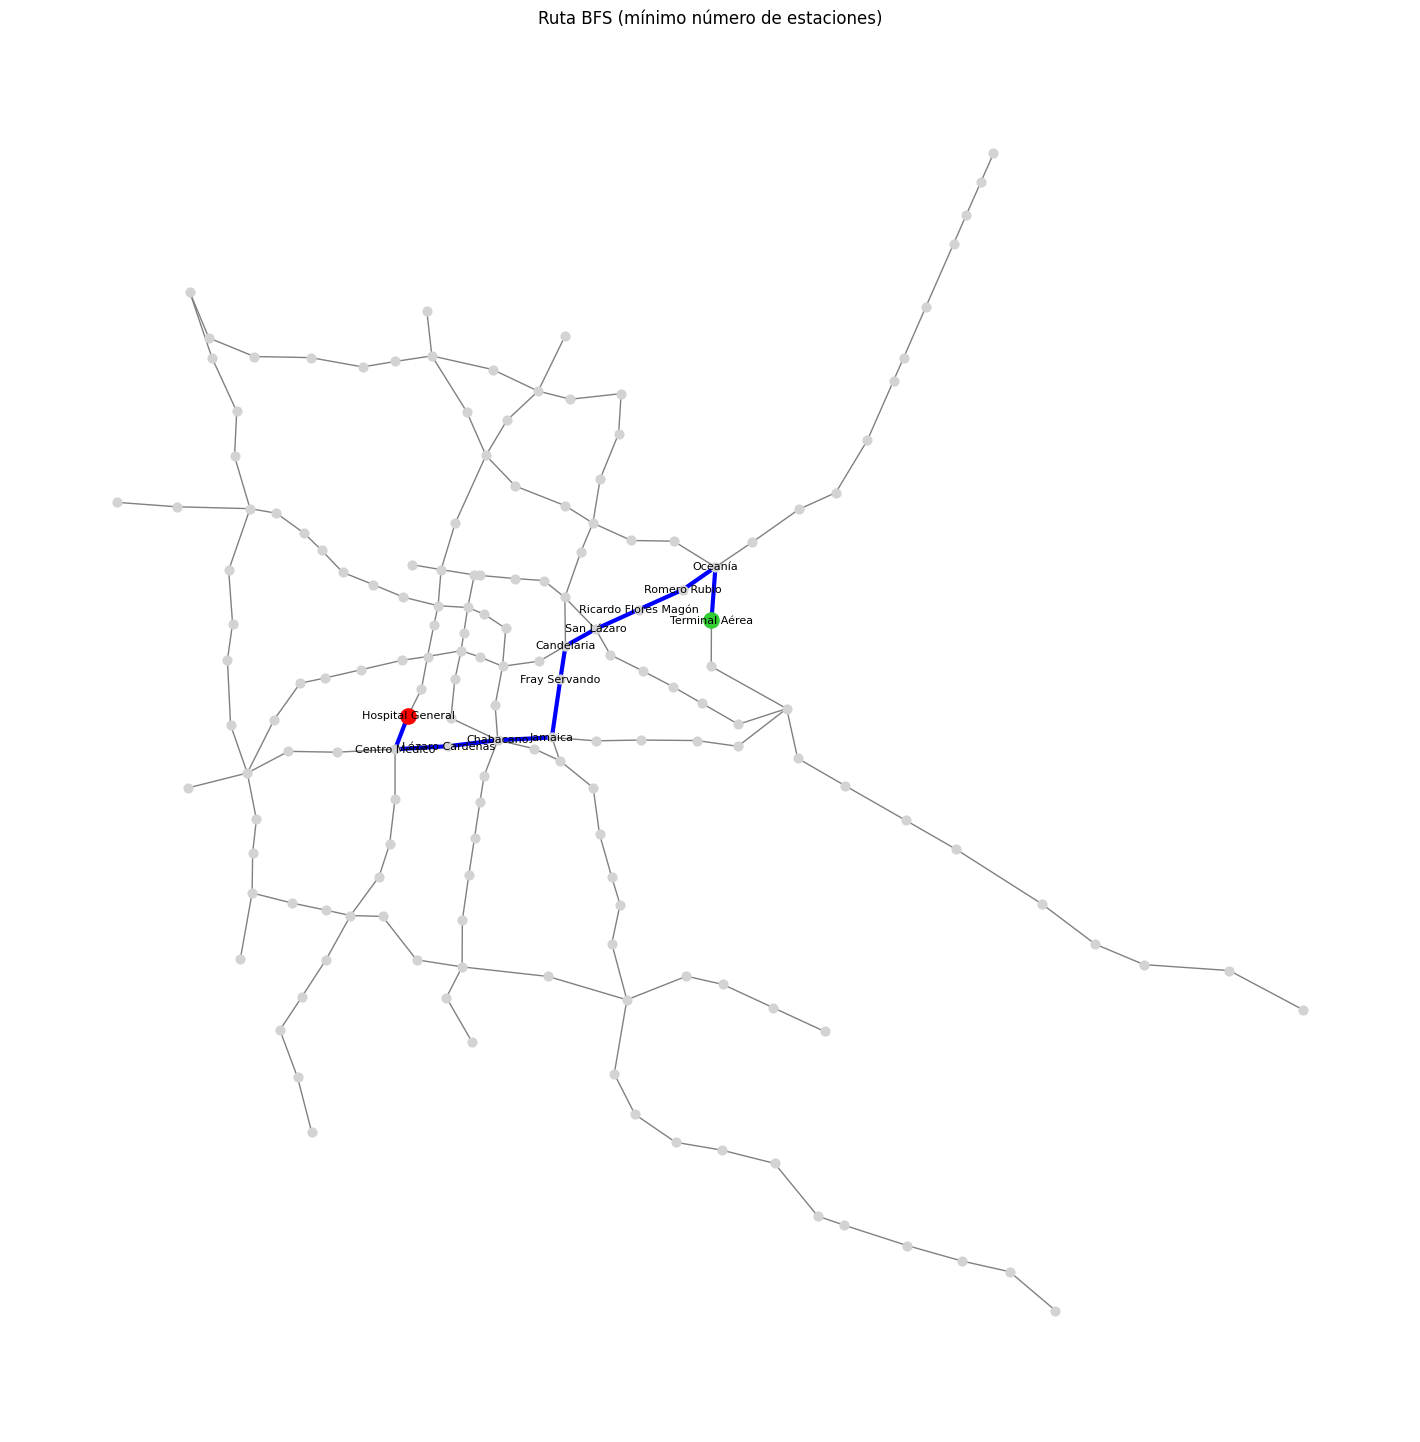

In [6]:
plot_route(G, ruta, pos, color="blue", title="Ruta BFS (mínimo número de estaciones)")

For the second problem I’ll be using two different algorithms: A* and Dijkstra. Both of them are good options, but each has its own pros and cons.

A* is usually much faster than Dijkstra because it uses a heuristic — basically a clue that suggests the direction in which the goal might be. This helps the algorithm avoid exploring unnecessary paths. However, if the heuristic is not admissible (meaning it overestimates the real cost), A* might fail to find the most optimal route. Therefore, defining an admissible heuristic is essential for A* to work correctly.

On the other hand, Dijkstra explores all possible directions and expands nodes strictly based on the real accumulated cost. This makes it slower, but it always guarantees finding the truly shortest path in terms of total distance (meters, in this case).

#### DIJKSTRA

In [7]:
import heapq

def dijkstra(G, start, goal):
    pq = [(0, start, [start])]
    visited = set()

    while pq:
        cost, node, path = heapq.heappop(pq)

        if node in visited:
            continue
        visited.add(node)

        if node == goal:
            return path, cost

        
        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                weight = G[node][neighbor]["weight"] 
                new_cost = cost + weight
                heapq.heappush(pq, (new_cost, neighbor, path + [neighbor]))

    return None, float("inf")


In [8]:
ruta, distancia = dijkstra(G, "Terminal Aérea", "Hospital General")

print("Ruta:", ruta)
print("Distancia total (m):", distancia)


Ruta: ['Terminal Aérea', 'Oceanía', 'Romero Rubio', 'Ricardo Flores Magón', 'San Lázaro', 'Candelaria', 'Merced', 'Pino Suárez', 'Isabel la Católica', 'Salto del Agua', 'Balderas', 'Niños Héroes', 'Hospital General']
Distancia total (m): 8616.0


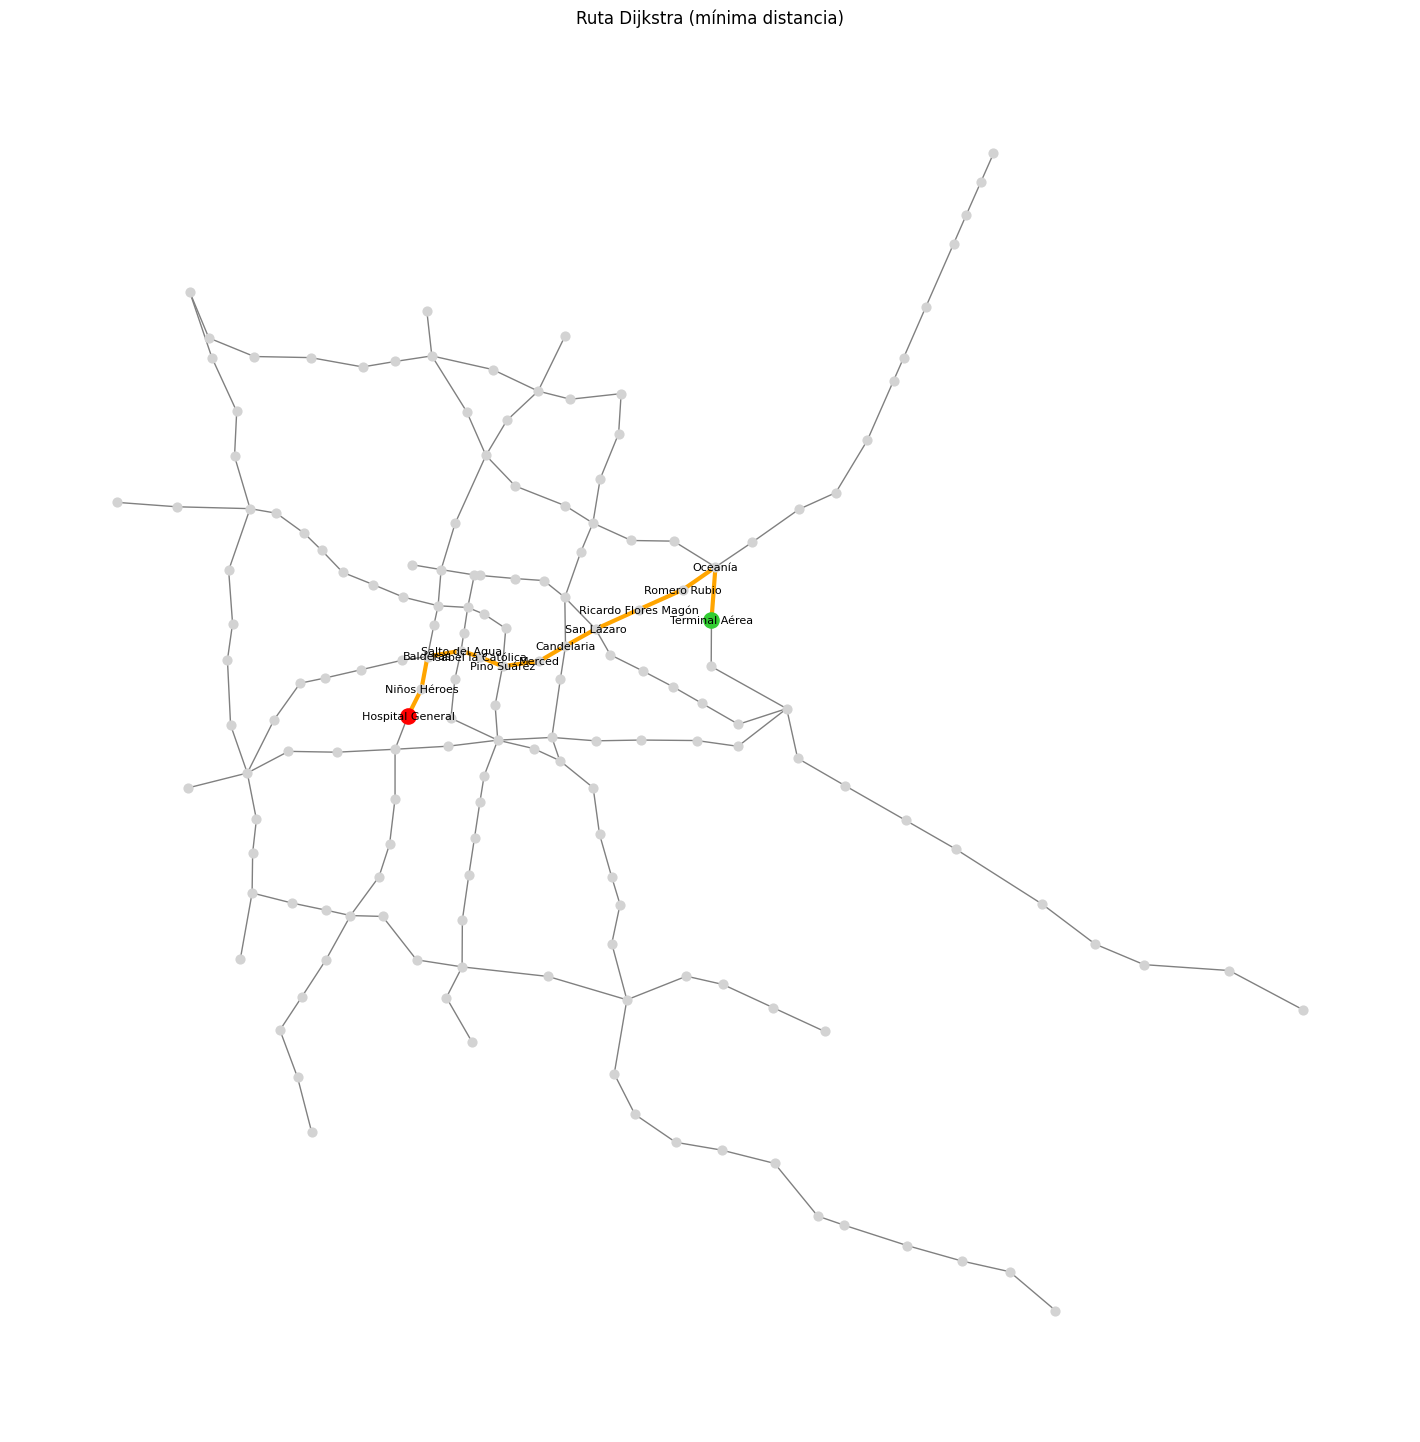

In [9]:
plot_route(G, ruta, pos, color="orange", title="Ruta Dijkstra (mínima distancia)")


#### A*
Before running A*, we need to define a heuristic. In this problem, the only cost we have is the distance in meters between stations. Because of that, we can use the Haversine distance as our heuristic.

The Haversine formula computes the shortest path between two points over the surface of a sphere (in this case, Earth). which is always less than or equal to the actual metro-rail distance between stations.

In [ ]:
import heapq
import math

def heuristica(G, nodo, meta):
    # Radius of the earth on meters
    R = 6371000  

    lat1 = math.radians(G.nodes[nodo]["y"])
    lon1 = math.radians(G.nodes[nodo]["x"])
    lat2 = math.radians(G.nodes[meta]["y"])
    lon2 = math.radians(G.nodes[meta]["x"])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    return R * c


def a_star(G, inicio, meta):
    # priority queue: (f, g, node, path)
    pq = [(0, 0, inicio, [inicio])]
    visitados = set()

    while pq:
        f, g, actual, ruta = heapq.heappop(pq)

        if actual in visitados:
            continue
        visitados.add(actual)

        if actual == meta:
            return ruta, g  # final path, cost

        for vecino, datos in G[actual].items():
            peso = datos["weight"]
            g_nuevo = g + peso
            h = heuristica(G, vecino, meta)
            f_nuevo = g_nuevo + h

            heapq.heappush(pq, (f_nuevo, g_nuevo, vecino, ruta + [vecino]))

    return None, float("inf")


In [11]:
ruta_a, costo_a = a_star(G, "Terminal Aérea", "Hospital General")

print("Ruta A*:", ruta_a)
print("Costo total (m):", costo_a)


Ruta A*: ['Terminal Aérea', 'Oceanía', 'Romero Rubio', 'Ricardo Flores Magón', 'San Lázaro', 'Candelaria', 'Merced', 'Pino Suárez', 'Isabel la Católica', 'Salto del Agua', 'Balderas', 'Niños Héroes', 'Hospital General']
Costo total (m): 8616.0


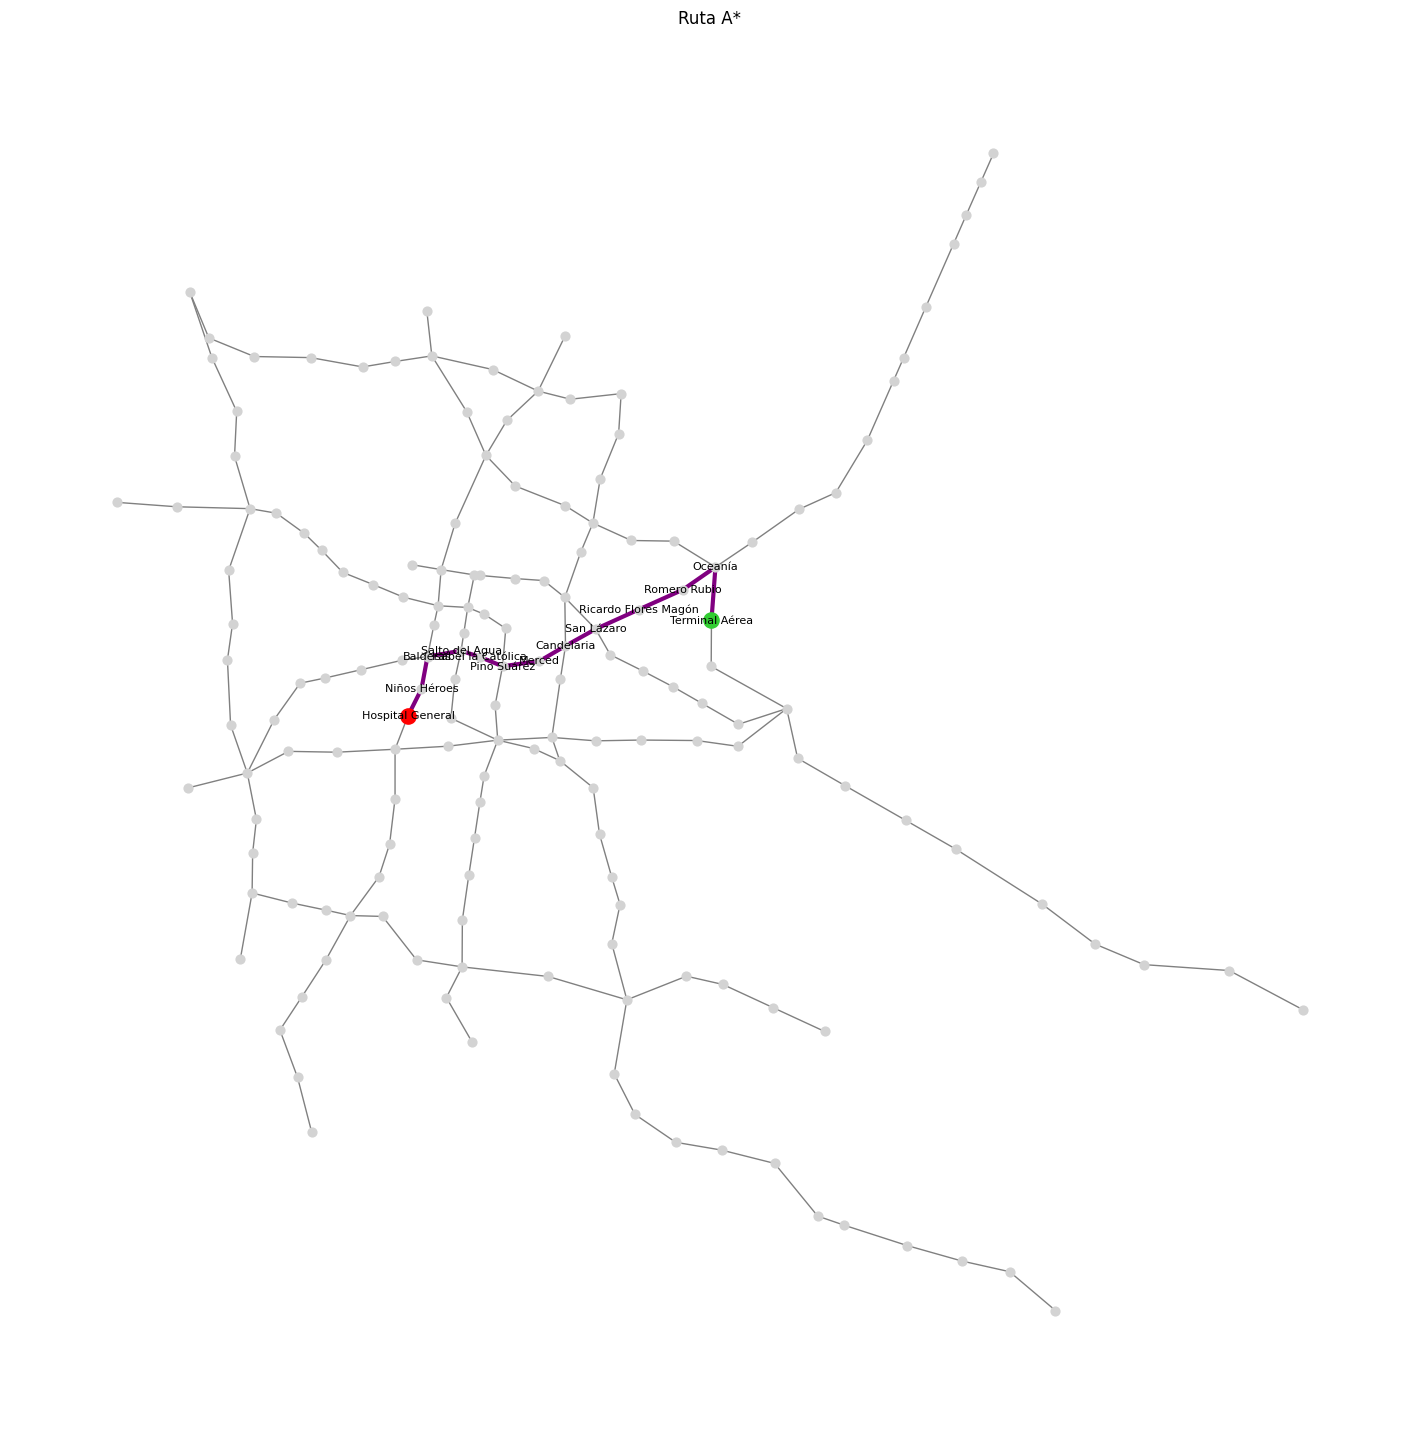

In [12]:
plot_route(G, ruta_a, pos, color="purple", title="Ruta A*")



=== Salto del Agua → Agrícola Oriental ===
BFS:
  Ruta: ['Salto del Agua', 'Doctores', 'Obrera', 'Chabacano', 'Jamaica', 'Mixiuhca', 'Velódromo', 'Ciudad Deportiva', 'Puebla', 'Pantitlán', 'Agrícola Oriental']
  Nodos explorados: 115
Dijkstra:
  Ruta: ['Salto del Agua', 'Isabel la Católica', 'Pino Suárez', 'Merced', 'Candelaria', 'San Lázaro', 'Moctezuma', 'Balbuena', 'Boulevard Puerto Aéreo', 'Gómez Farías', 'Zaragoza', 'Pantitlán', 'Agrícola Oriental']
  Distancia: 9014.0
  Nodos explorados: 126
A*:
  Ruta: ['Salto del Agua', 'Isabel la Católica', 'Pino Suárez', 'Merced', 'Candelaria', 'San Lázaro', 'Moctezuma', 'Balbuena', 'Boulevard Puerto Aéreo', 'Gómez Farías', 'Zaragoza', 'Pantitlán', 'Agrícola Oriental']
  Distancia: 9014.0
  Nodos explorados: 20


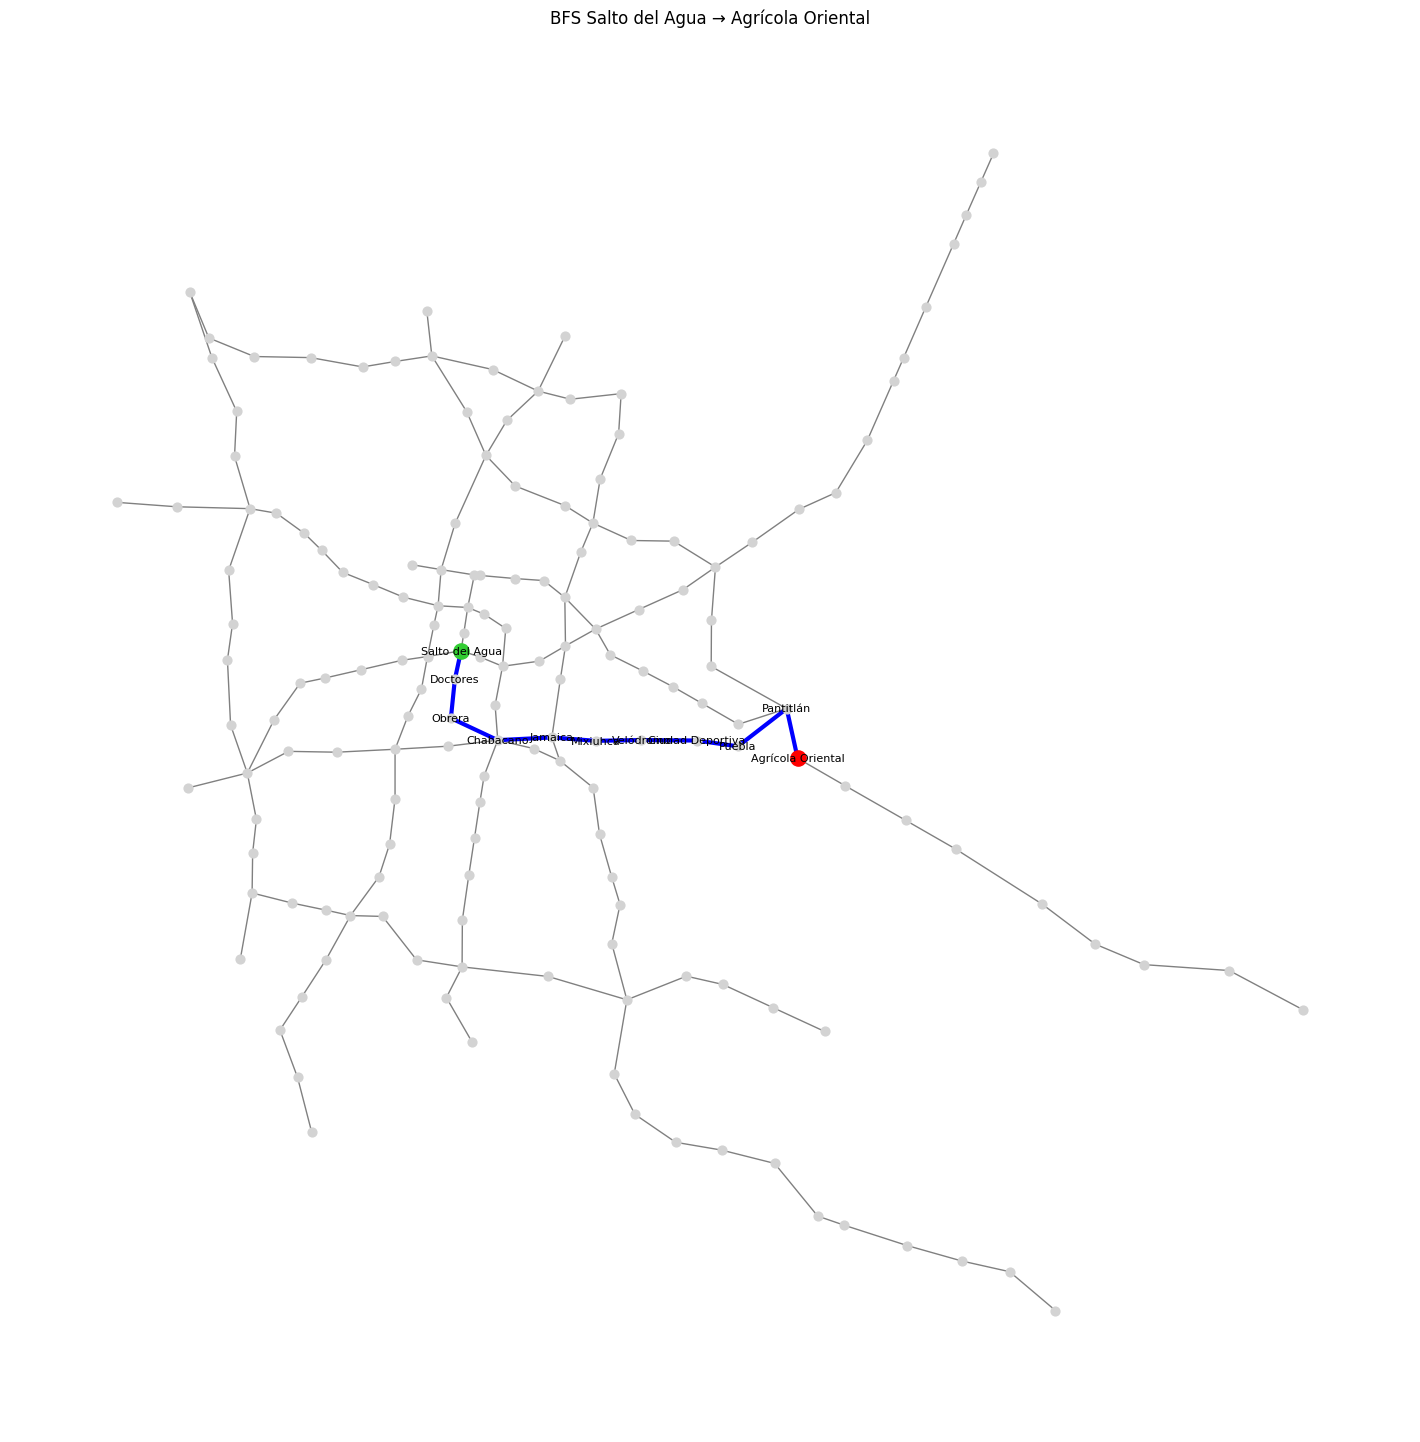

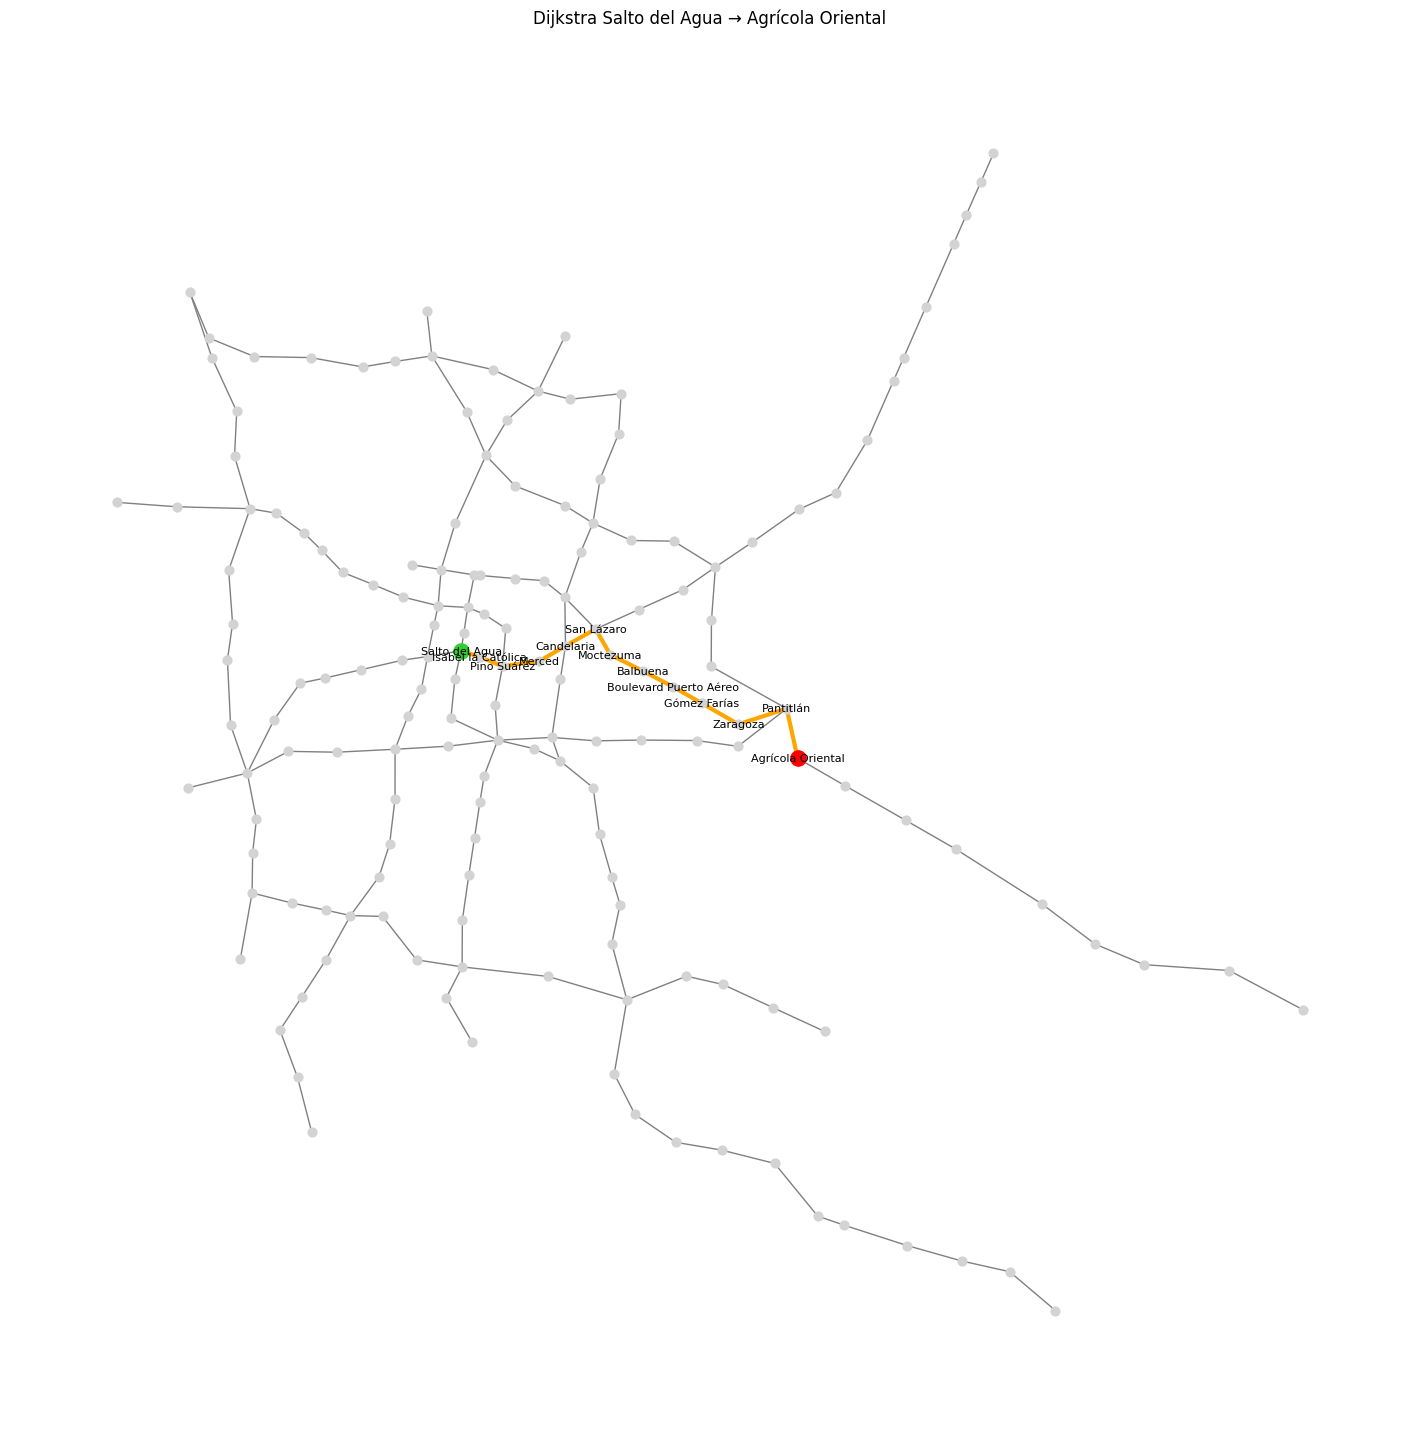

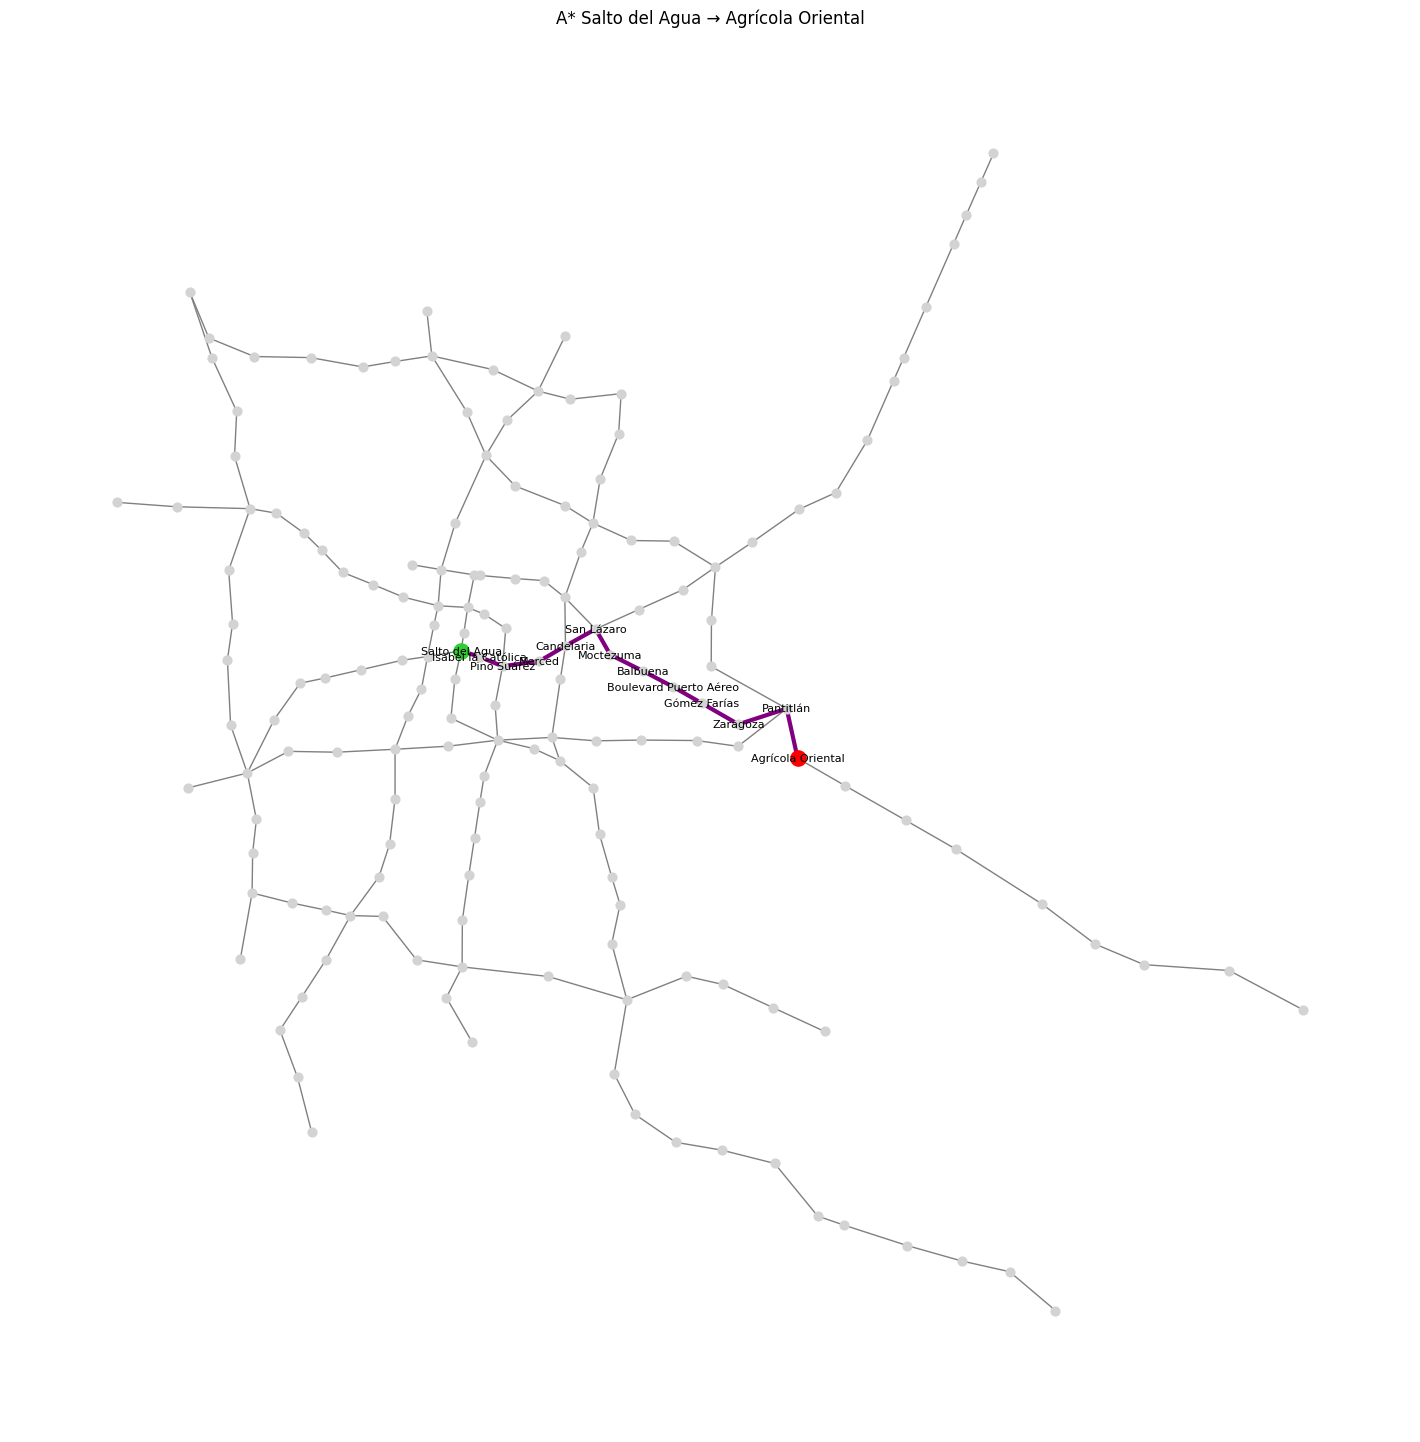


=== Universidad → Ciudad Azteca ===
BFS:
  Ruta: ['Universidad', 'Copilco', 'Miguel Ángel de Quevedo', 'Viveros/Derechos Humanos', 'Coyoacán', 'Zapata', 'División del Norte', 'Eugenia', 'Etiopía/Plaza de la Transparencia', 'Centro Médico', 'Lázaro Cardenas', 'Chabacano', 'Jamaica', 'Fray Servando', 'Candelaria', 'San Lázaro', 'Ricardo Flores Magón', 'Romero Rubio', 'Oceanía', 'Deportivo Oceanía', 'Bosques de Aragón', 'Villa de Aragón', 'Nezahualcóyotl', 'Impulsora', 'Río de los Remedios', 'Múzquiz', 'Ecatepec', 'Olímpica', 'Plaza Aragón', 'Ciudad Azteca']
  Nodos explorados: 163
Dijkstra:
  Ruta: ['Universidad', 'Copilco', 'Miguel Ángel de Quevedo', 'Viveros/Derechos Humanos', 'Coyoacán', 'Zapata', 'División del Norte', 'Eugenia', 'Etiopía/Plaza de la Transparencia', 'Centro Médico', 'Hospital General', 'Niños Héroes', 'Balderas', 'Salto del Agua', 'Isabel la Católica', 'Pino Suárez', 'Merced', 'Candelaria', 'San Lázaro', 'Ricardo Flores Magón', 'Romero Rubio', 'Oceanía', 'Deportivo O

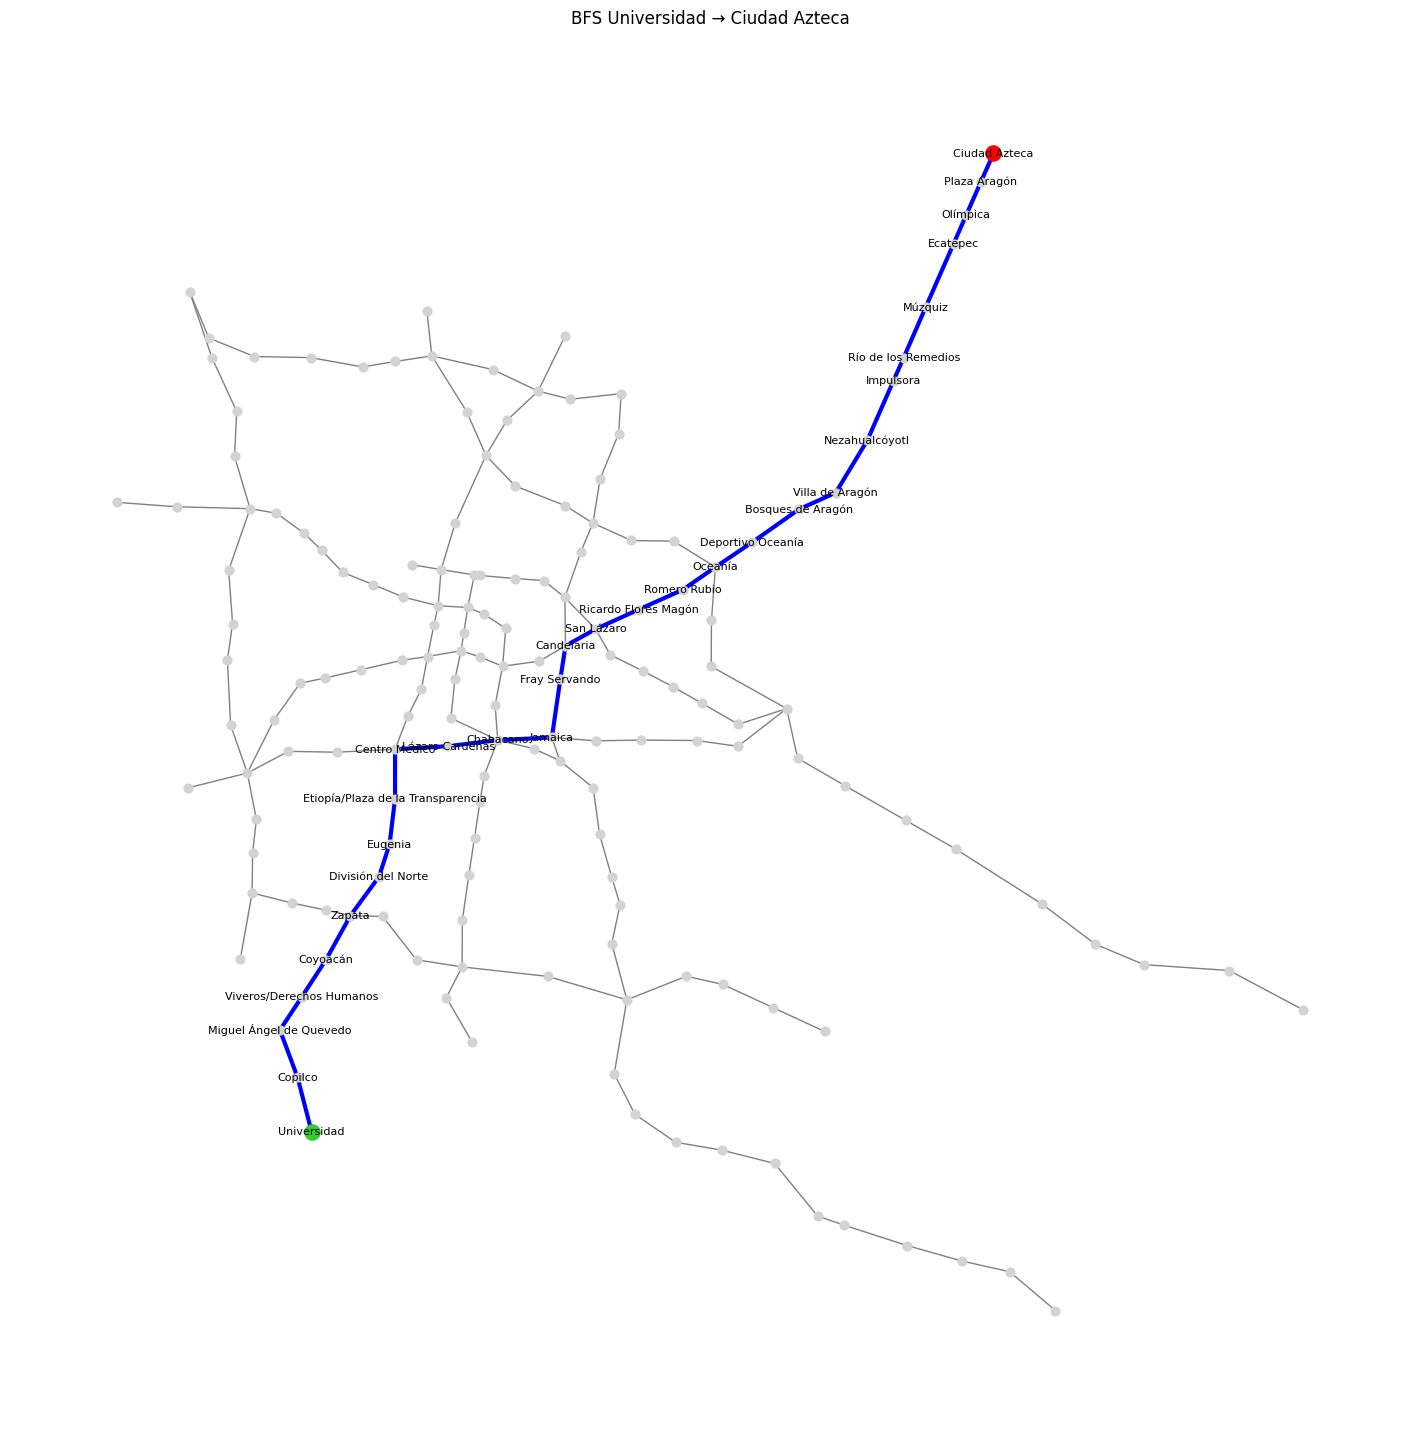

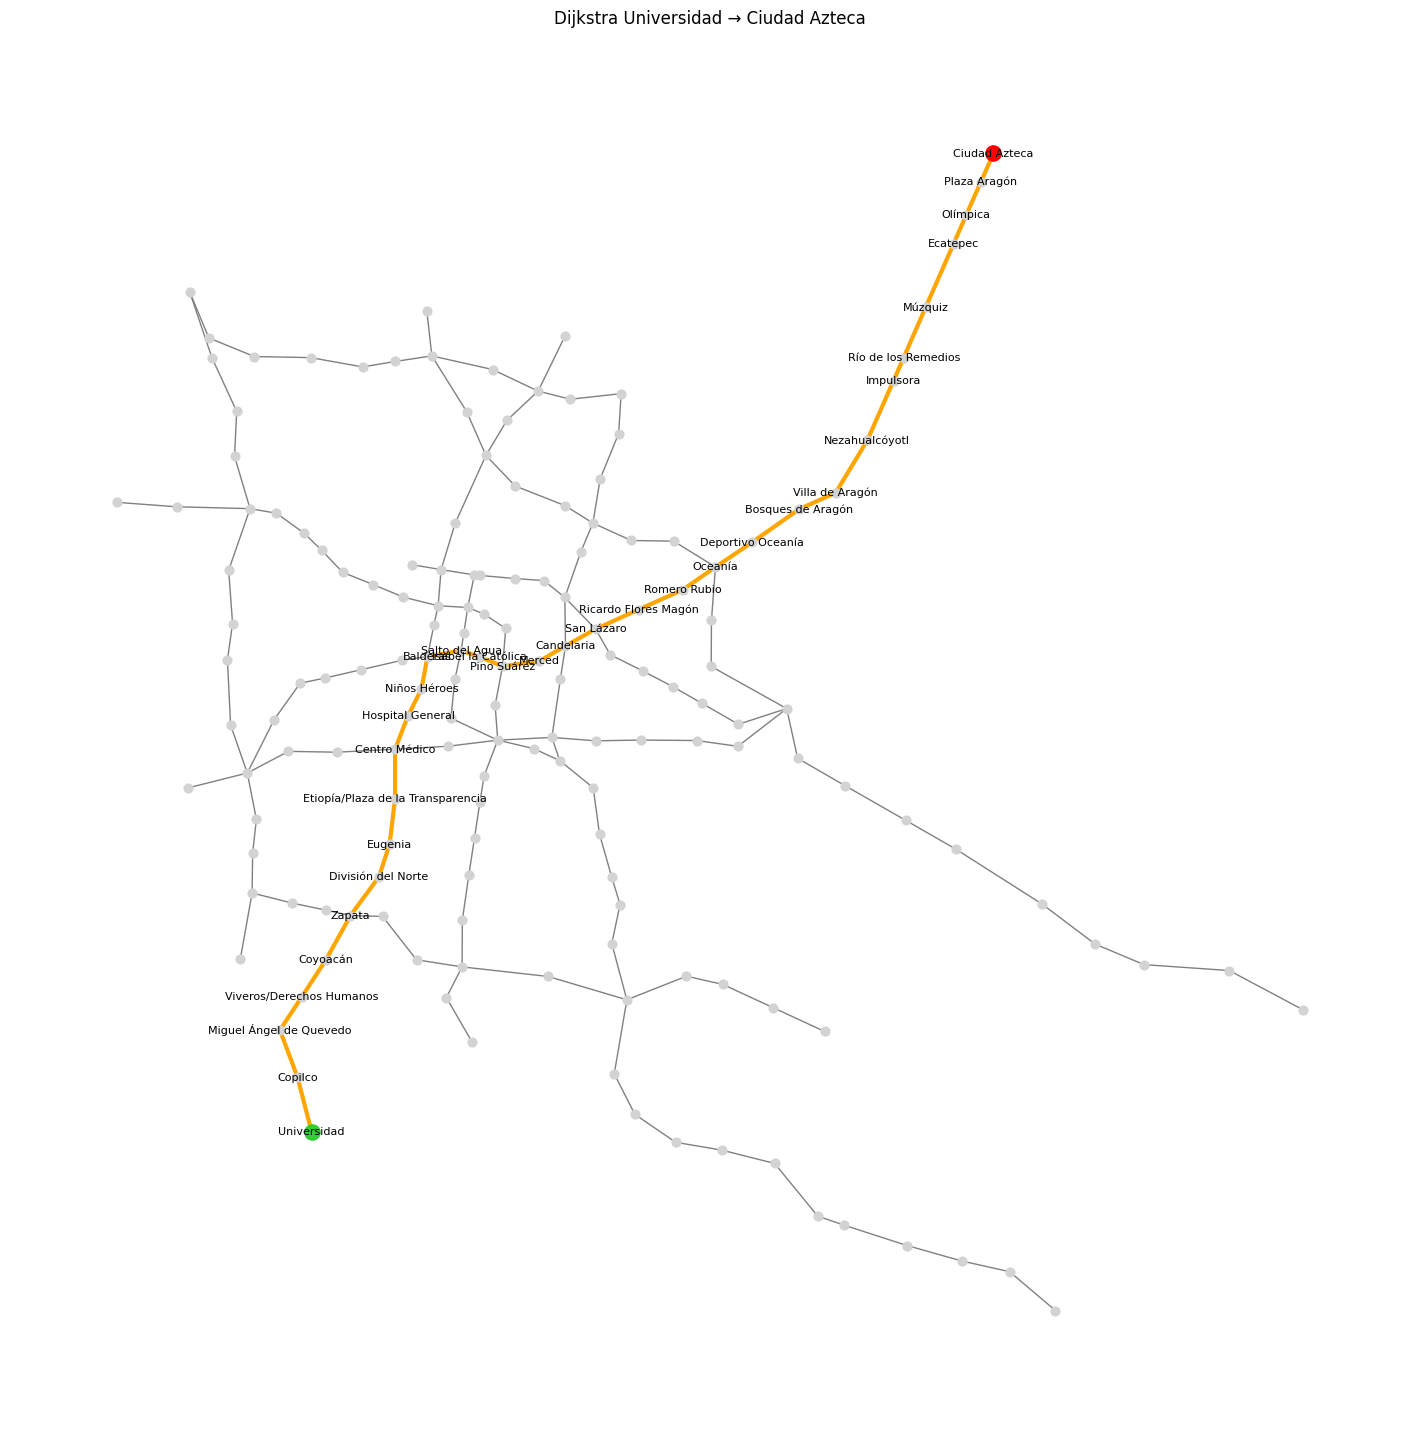

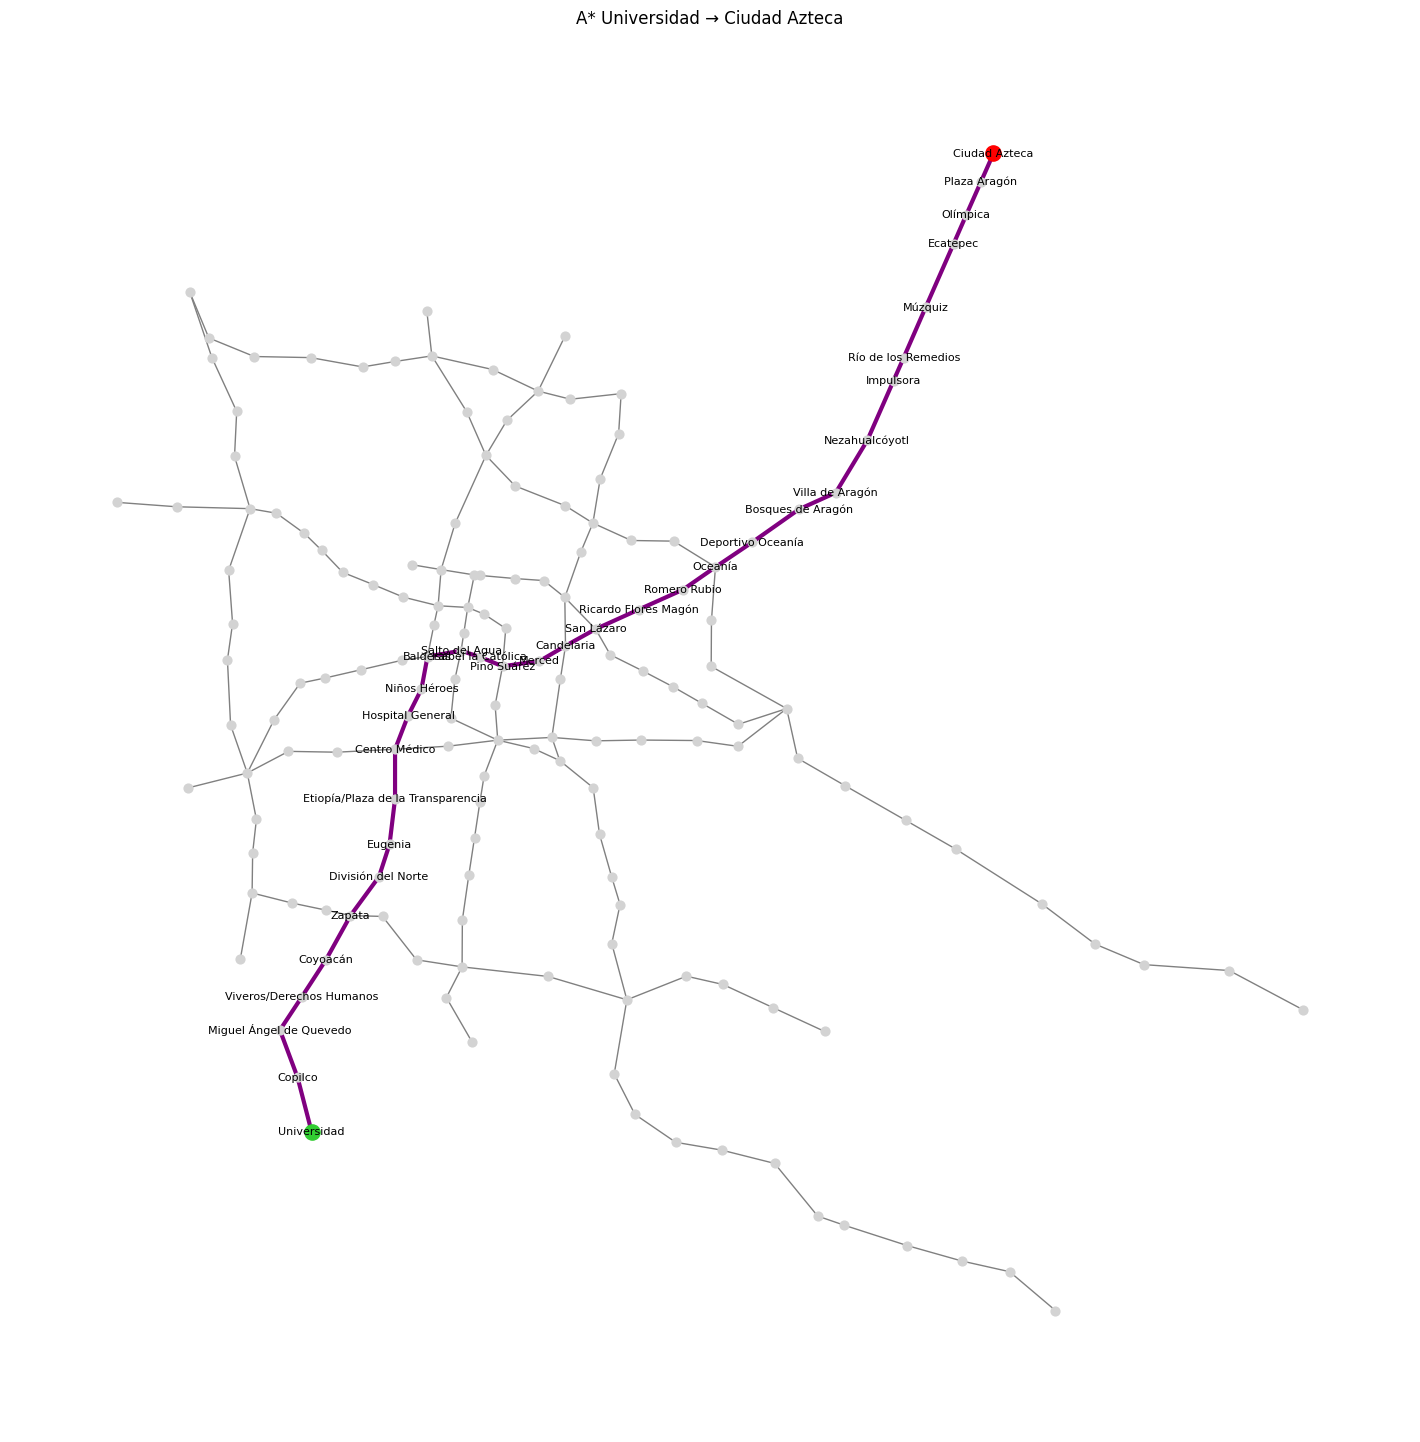

In [13]:
# I created another .py with the algorithms but adding a counting nodes feature for each one of them
from funciones import bfs_with_count, a_star_with_count, dijkstra_with_count
pares = [
    ("Salto del Agua", "Agrícola Oriental"),
    ("Universidad", "Ciudad Azteca")
]

for inicio, meta in pares:
    print(f"\n=== {inicio} → {meta} ===")

    ruta_bfs, n_bfs = bfs_with_count(G, inicio, meta)
    ruta_d, dist_d, n_d = dijkstra_with_count(G, inicio, meta)
    ruta_a, dist_a, n_a = a_star_with_count(G, inicio, meta)

    print("BFS:")
    print("  Ruta:", ruta_bfs)
    print("  Nodos explorados:", n_bfs)

    print("Dijkstra:")
    print("  Ruta:", ruta_d)
    print("  Distancia:", dist_d)
    print("  Nodos explorados:", n_d)

    print("A*:")
    print("  Ruta:", ruta_a)
    print("  Distancia:", dist_a)
    print("  Nodos explorados:", n_a)

    # graficar
    plot_route(G, ruta_bfs, pos, color="blue", title=f"BFS {inicio} → {meta}")
    plot_route(G, ruta_d, pos, color="orange", title=f"Dijkstra {inicio} → {meta}")
    plot_route(G, ruta_a, pos, color="purple", title=f"A* {inicio} → {meta}")


### COMPARISON AND ANALYSIS

#### Are the routes found using BFS, DIJKSTRA and A* always the same?
-No.
BFS only cares about finding the route with the least number of stations, completely ignoring the real physical distance. Because of that, its solution often looks very different from the one found by Dijkstra or A*.
On the other hand, Dijkstra and A* both optimize actual distance in meters, so their routes usually match. The difference is how they explore the graph, not the final route itself.

#### What are the main differences between the three algorithms in terms of efficieny (explored nodes) and the quality of the route?
BFS is efficient when the only goal is minimizing the number of stations, but it provides the worst solution in terms of real distance. It can explore nodes in directions that have nothing to do with the actual path towards the destination.

Dijkstra guarantees the optimal route in distance but usually explores more nodes

A* tries to be better than Dijkstra by using a heuristic that points it towards the goal. If the heuristic is informative, it explores less nodes and reaches the solution faster.

#### In which cases did the heuristic of the A* algorithm became useful or not that effective?
In my tests, the heuristic was very effective, since i used an admissible heuristic (the Haversine distance), A* was guaranteed to find the same optimal route as Dijkstra, but with a much smaller search space. A* explored way fewer nodes than Dijkstra and BFS in both cases
    